In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        
        self.device = device
        
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration

        img = read_image(self.df.loc[idx, 'img_path'])[:3,:,:]
        filename = self.df.loc[idx, 'filename']
        sign = self.df.loc[idx, 'sign']
        
        if self.transform:
            img = self.transform(img)

        return img, filename, sign
    
    def getData(self):
        return list(self)

In [6]:
def createDataFrame():
    
    train_df = pd.read_csv('../data/train.csv')
    train_df['img_path'] = '../data/avia-train/avia-train/' + train_df['filename'] + '.png'
    
    test_df = pd.read_csv('../data/test.csv')
    test_df['img_path'] = '../data/avia-test/avia-test/' + test_df['filename'] + '.png'
    test_df['sign'] = -1
    
    test_e_df = pd.read_csv('../data/test_extended.csv', index_col='filename')
    
    test_e_df = test_e_df.drop(test_df['filename'])
    test_e_df['filename'] = test_e_df.index
    
    test_e_df['img_path'] = '../data/avia-test-extended/avia-test-extended/' + test_e_df['filename'] + '.jpeg'
    test_e_df['sign'] = -1
    
    df = pd.concat((train_df, test_df, test_e_df)).reset_index(drop=True)
    
    df['sign'] = df['sign'].astype('float64')
    
    return df

In [7]:
def createDataLoader(df, batch_size=None, shuffle=False, transform=None):

    batch_size = batch_size if batch_size else len(df)
    
    dataset = CustomImageDataset(df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataset, dataloader

In [8]:
df = createDataFrame()

In [9]:
model = models.resnet152(pretrained=True)

for param in list(model.parameters())[:-4]:
    param.require = False
    
model.fc = torch.nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestModel': None}
    
    epochs = 15
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=100, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=100, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device).float().reshape(-1, 1)
            
            y_predict = model(X)

            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestModel'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            log['bestModel'] = model
            log['bestEpoch'] = epoch + 1

        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 15 | Train loss: 0.03323954523234333 | Val loss: 0.011112748804162182
Epoch: 2 / 15 | Train loss: 0.014344897865501034 | Val loss: 0.009384708649050149
Epoch: 3 / 15 | Train loss: 0.010039551062490716 | Val loss: 0.008537520591672215
Epoch: 4 / 15 | Train loss: 0.009026292430977505 | Val loss: 0.007188432938641026
Epoch: 5 / 15 | Train loss: 0.007836586749227905 | Val loss: 0.007047688861983636
Epoch: 6 / 15 | Train loss: 0.0066593701665544035 | Val loss: 0.006122292556230807
Epoch: 7 / 15 | Train loss: 0.0062188431735143036 | Val loss: 0.0056955094619225415
Epoch: 8 / 15 | Train loss: 0.0055483553120160446 | Val loss: 0.008578299061535665
Epoch: 9 / 15 | Train loss: 0.005390806626970318 | Val loss: 0.006424472336509516
Epoch: 10 / 15 | Train loss: 0.004541885546124802 | Val loss: 0.005376967583923409
Epoch: 11 / 15 | Train loss: 0.0043944418988444 | Val loss: 0.005626550271353196
Epoch: 12 / 15 | Train loss: 0.003947462705052813 | Val loss: 0.007138794236299064
Epoch: 13 / 

10


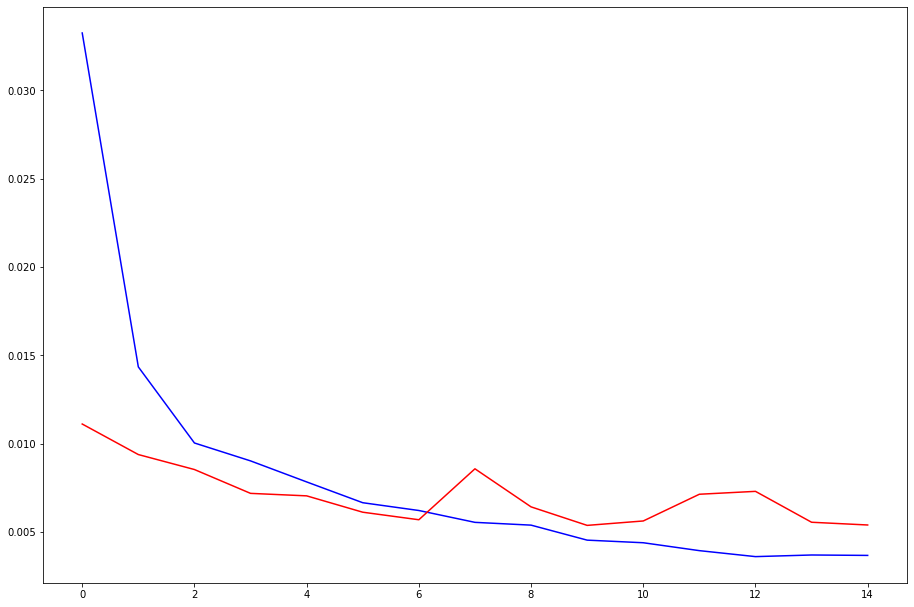

In [11]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [12]:
model = log['bestModel']

In [17]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df[df['sign'] == -1]
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=100, shuffle=True, transform=testTransform)
    
    filenames = []
    predicteds = []
    
    for X, filename, _ in test_dataloader:
        X = X.to(device)
        
        y_predicted1 = model(X)
        y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
        y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
        y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))
            
        y_predicted = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)
        
        y_predicted = y_predicted.cpu()
        
        filenames += filename
        predicteds.append(y_predicted)
        
predicteds = torch.cat(predicteds, 0)

Wall time: 4min 25s


In [18]:
predict_df = pd.DataFrame({
    'sign': predicteds,
    'filename': filenames
})

In [19]:
predict_df

sign                              filename
0       0.000000e+00  cc61de57-b17a-48c3-9f6a-68459d8d5f60
1       1.332778e-39  38719c18-4568-40bf-8ec2-25ffa4229a3c
2       0.000000e+00  9cef509c-f224-4c0c-aca1-97ffb27ebe04
3       0.000000e+00  3c3de7fe-47c2-492a-8f49-200c9c4d8a80
4       1.370102e-18  0faed8b6-1160-46a5-a866-3ac021cf39b8
...              ...                                   ...
100995  0.000000e+00  4823ec36-a515-452c-82d0-e164df1c97cc
100996  0.000000e+00  ba56e809-d5bb-4449-9278-5f8e093033be
100997  4.063269e-38  1367d1a3-abe8-48c5-a13b-2369a9ed22d0
100998  0.000000e+00  90035023-5933-482a-bdbd-4e2b9fc3affb
100999  3.709080e-32  7819c264-433b-4eef-a0ed-31f2dd93d77b

[101000 rows x 2 columns]

In [20]:
predict_df.to_csv('../predict/8.csv', index=False)